### General results for all cell types. 


* general counts of credible sets
* distributions of TSS-lead variant distance (TODO)
* annotation enrichments (TODO)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [ ]:
# get outputs from a config file


In [2]:
prefix = '/home/klawren/oak/pcqtls'
tissue_df = pd.read_csv(f"{prefix}/data/references/selected_tissue_ids.csv", header=0)
tissue_ids = list(tissue_df['Tissue'])


### How many credible sets across tissues

In [3]:
def get_num_cs(susie_df):
    return len(susie_df.groupby(['phenotype_id','cs_id']))

susie_control={}
susie_pc1={}
susie_pc2={}

for tissue_id in tissue_df['Tissue']:
    susie_control[tissue_id] = pd.read_csv(f'/home/klawren/oak/pcqtls/output/control_eqtl/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t', index_col=0)
    susie_pc1[tissue_id] = pd.read_csv(f'/home/klawren/oak/pcqtls/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_1.susie.txt', sep='\t', index_col=0)
    susie_pc2[tissue_id] = pd.read_csv(f'/home/klawren/oak/pcqtls/output/pcqtl/{tissue_id}/{tissue_id}.v8.pc_2.susie.txt', sep='\t', index_col=0)

In [4]:
counts = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'num_control': [get_num_cs(susie_control[t]) for t in tissue_df['Tissue']], 
                       'num_pc1': [get_num_cs(susie_pc1[t]) for t in tissue_df['Tissue']], 
                       'num_pc2': [get_num_cs(susie_pc2[t]) for t in tissue_df['Tissue']], 
                       'num_clusters':[len(pd.read_csv(f'/home/klawren/oak/pcqtls/output/clusters_tami/{t}_clusters_all_chr.csv.txt')) for t in tissue_df['Tissue']]})


/local/scratch/klawren/slrmtmp.42709032/ipykernel_49427/1959445384.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['eqtl', 'pc1qtl', 'pc2qtl', 'clusters'])


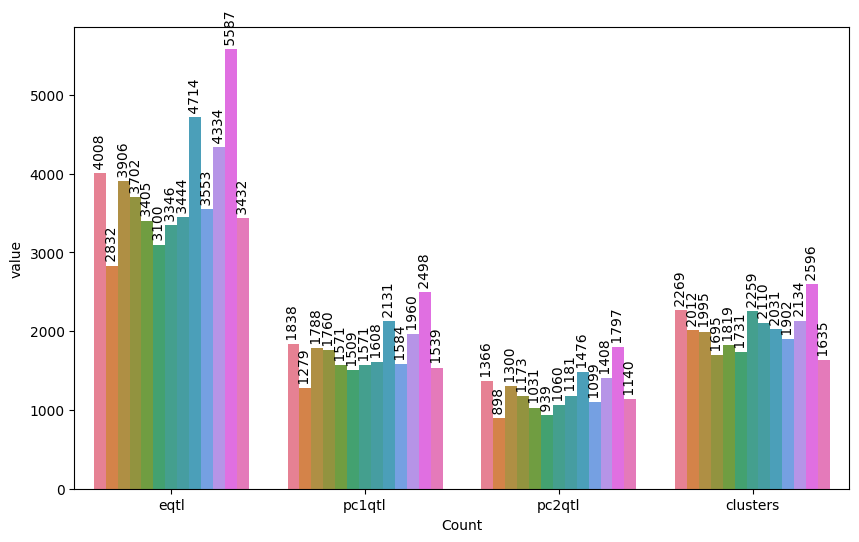

In [14]:
f, ax = plt.subplots(figsize=(10, 6))
y = sns.barplot(pd.melt(counts, id_vars=['tissue']), y='value', hue='tissue', x='variable', ax=ax)
for i in range(len(y.containers)):
    labels = [' ' + str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels, rotation=90)
ax.set_xlabel('Count')
ax.set_xticklabels(['eqtl', 'pc1qtl', 'pc2qtl', 'clusters'])
plt.legend([],[], frameon=False)

plt.show()

In [61]:
# distribution of pc vs eqlts

# concatenate data over tissues
full_esusie_df = pd.concat(list(susie_control.values()))
full_pc1susie_df = pd.concat(list(susie_pc1.values()))
full_pc2susie_df = pd.concat(list(susie_pc2.values()))

# count how many qtls for each gene 
full_pc1susie_df['gene_id_list'] = full_pc1susie_df['phenotype_id'].str.split('_').str[:-1]
pc1qlts_per_gene = full_pc1susie_df.explode('gene_id_list').groupby('gene_id_list')['cs_id'].nunique()

full_pc2susie_df['gene_id_list'] = full_pc2susie_df['phenotype_id'].str.split('_').str[:-1]
pc2qlts_per_gene = full_pc2susie_df.explode('gene_id_list').groupby('gene_id_list')['cs_id'].nunique()

full_esusie_df['gene_id'] = full_esusie_df['phenotype_id'].str.split('_').str[-1]
full_esusie_df['phenotype_cs_id'] = full_esusie_df['phenotype_id'] + '_' + full_esusie_df['cs_id'].astype(str)
eqlts_per_gene = full_esusie_df.groupby('gene_id')['phenotype_cs_id'].nunique()

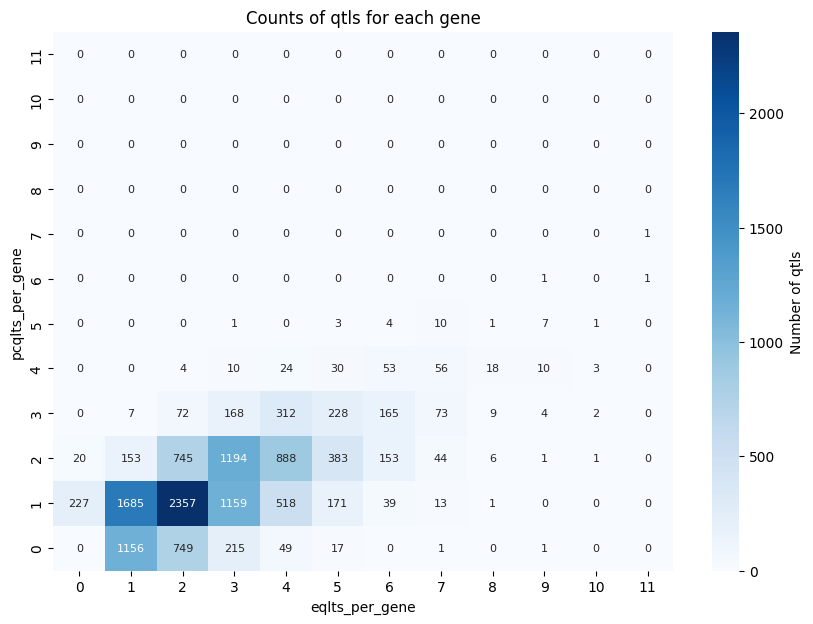

In [24]:
counts = pd.DataFrame({'eqlts_per_gene':eqlts_per_gene, 'pc1qlts_per_gene':pc1qlts_per_gene, 'pc2qlts_per_gene':pc2qlts_per_gene})
counts.replace(np.NAN, 0, inplace=True)
counts['pcqlts_per_gene'] = counts['pc1qlts_per_gene'] + counts['pc2qlts_per_gene']

# make the plot

fig, ax = plt.subplots(figsize=(10,7))

# get the 2d histogram bin values
bins=range(int(counts.max().max())+2)
hist_values, x_edges, y_edges = np.histogram2d(counts['pcqlts_per_gene'], counts['eqlts_per_gene'], bins=bins)
df_hist = pd.DataFrame(hist_values)
sns.heatmap(df_hist.astype(int), cbar_kws={'label': 'Number of qtls'}, cmap='Blues', annot=True, annot_kws={"size":8}, ax=ax, fmt='d')
ax.invert_yaxis()
ax.set_ylabel('pcqlts_per_gene')
ax.set_xlabel('eqlts_per_gene')
ax.set_title('Counts of qtls for each gene')
plt.show()

In [47]:
# can do this per cluster instead of per gene

# count how many qtls for each gene 
full_pc1susie_df['cluster_id'] = full_pc1susie_df['phenotype_id'].str.split('_pc1').str[0]
pc1qlts_per_cluster = full_pc1susie_df.groupby('cluster_id')['cs_id'].nunique()

full_pc2susie_df['cluster_id'] = full_pc2susie_df['phenotype_id'].str.split('_pc2').str[0]
pc2qlts_per_cluster = full_pc2susie_df.groupby('cluster_id')['cs_id'].nunique()

full_esusie_df['cluster_id'] = full_esusie_df['phenotype_id'].str.split('_e').str[0]
full_esusie_df['phenotype_cs_id'] = full_esusie_df['phenotype_id'] + '_' + full_esusie_df['cs_id'].astype(str)
eqlts_per_cluster = full_esusie_df.groupby('cluster_id')['phenotype_cs_id'].nunique()


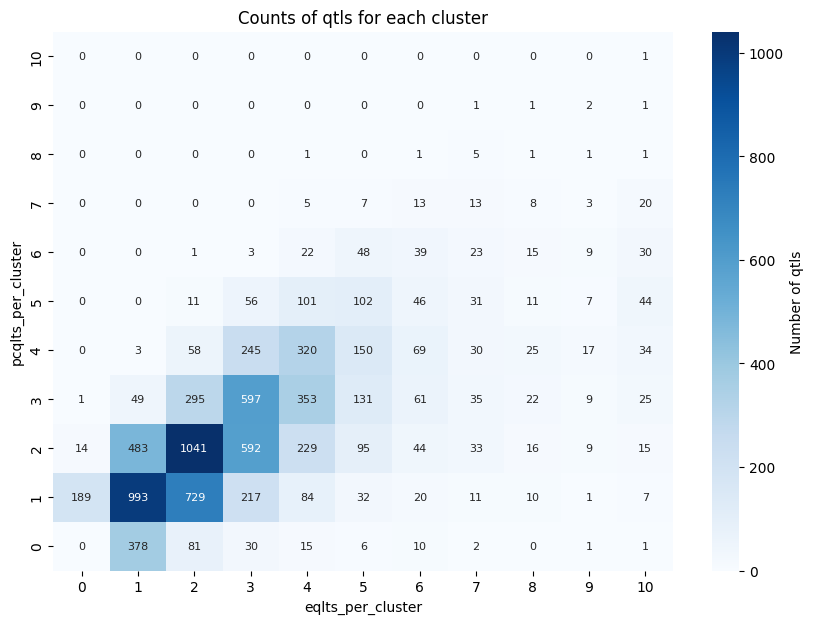

In [69]:
counts = pd.DataFrame({'eqlts_per_cluster':eqlts_per_cluster, 'pc1qlts_per_cluster':pc1qlts_per_cluster, 'pc2qlts_per_cluster':pc2qlts_per_cluster})
counts.replace(np.NAN, 0, inplace=True)
counts['pcqlts_per_cluster'] = counts['pc1qlts_per_cluster'] + counts['pc2qlts_per_cluster']

# make the plot

fig, ax = plt.subplots(figsize=(10,7))

# get the 2d histogram bin values
clip=10
# uncomment this if you don't want it cliped
#clip=int(counts.max().max())
bins=range(clip+2)

hist_values, x_edges, y_edges = np.histogram2d(counts['pcqlts_per_cluster'].clip(0,clip), counts['eqlts_per_cluster'].clip(0,clip), bins=bins)
df_hist = pd.DataFrame(hist_values)
sns.heatmap(df_hist.astype(int), cbar_kws={'label': 'Number of qtls'}, cmap='Blues', annot=True, annot_kws={"size":8}, ax=ax, fmt='d')
ax.invert_yaxis()
ax.set_ylabel('pcqlts_per_cluster')
ax.set_xlabel('eqlts_per_cluster')
ax.set_title('Counts of qtls for each cluster')
plt.show()

In [21]:
# distribuition of distances from variant to gene tss